### Final project - Tracking of a maneuvering vehicle
#### Abramov Semen, Belikov Ilia, Nikolay Zherdev, Mikhail Kulbeda
#### Skoltech, 24.10.2018


The objectives of this assignment are to encourage you to think creatively and critically to extract a useful signal from noisy experimental data, find best estimation method of a dynamical process and make forecast of its future development.

In [110]:
import pandas as pd
import numpy as np
from math import pi
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from tqdm import tqdm_notebook as tqdm

from numpy import linalg as LA

init_notebook_mode(connected=True)

### What to do if your vehicle does a strong maneuver?

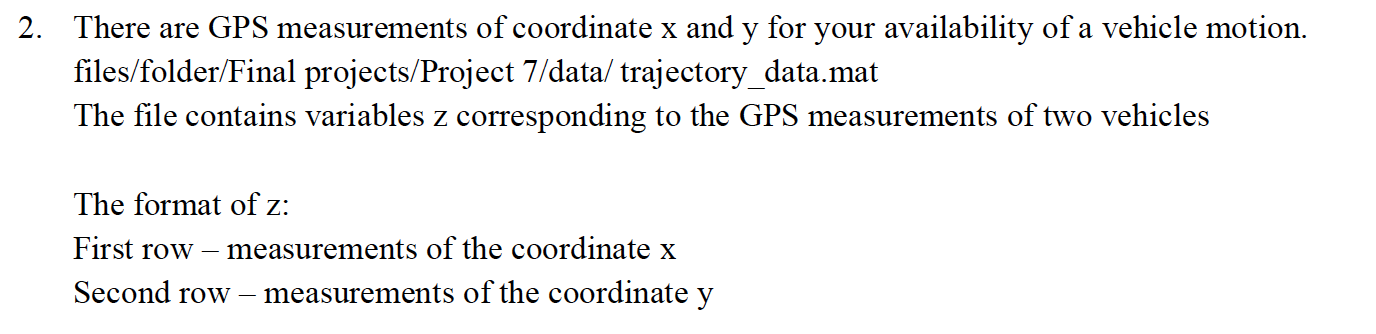

In [111]:
path = "/Users/sabramov/Downloads/edp_final_project/trajectory_data.txt"
gps = np.loadtxt(path)
msr_x = gps[:, 0]
msr_y = gps[:, 1]
z = np.column_stack((msr_x, msr_y))

In [112]:
data = [
    go.Scatter(
        x=msr_x,
        y=msr_y,
        name='measured trajectory',
        mode='markers'
    ),
]

layout= go.Layout(
    title= 'GPS-measured trajectory',
    xaxis= dict(
        title= 'X',
    ),
    yaxis=dict(
        title= 'Y',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

In [113]:
var_acc = 0.01**2
var_n = 10**2

S0 = np.array((0, 0, 0, 0))
P0 = np.eye(4)*(10**5) # 4x4

In [114]:
def kalman(msr, var_acc, var_n, T = 1, S0 = S0, P0 = P0):
    
    size = msr.shape
    
    F = np.array([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])
    G = np.array([[(T**2)/2, 0], [T, 0], [0, (T**2)/2], [0, T]])
    Q = G.dot(G.T)*var_acc # state noise
    H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
    R = np.array([[var_n, 0], [0, var_n]]) # measurement noise
    
    # allocate space for arrays
    P = np.zeros((size[0], 4, 4))
    X = np.zeros((size[0], 4))
    P_ = np.zeros((size[0], 4, 4))
    X_ = np.zeros((size[0], 4))
    K = np.zeros((size[0], 4, 2))
    v = np.zeros((size[0], 2))
    
    # intial guesses
    X_[0] = S0
    P_[0] = P0
    
    for k in range(1, size[0]):
        
        # Prediction
        X[k] = np.dot(F, X_[k-1])
        P[k] = np.dot(F, np.dot(P_[k-1], F.T)) + Q
        
        # Update
        K[k] = (P[k].dot(H.T)).dot(np.linalg.inv(H.dot(P[k].dot(H.T)) + R))
        v[k] = msr[k] -  np.dot(H, X[k]) # residual: measured minus predicted
        X_[k] = X[k] + K[k].dot(v[k])
        P_[k] = (np.eye(4) - np.dot(K[k], H)).dot(P[k])
    return X, X_, v

In [115]:
X, X_, r = kalman(z, var_acc = 0.01**2, var_n = 10**2)

In [116]:
data = [
    go.Scatter(
        x=msr_x,
        y=msr_y,
        name='measured trajectory',
        mode='markers'
    ),
    go.Scatter(
        x = X_[:, 0],
        y = X_[:, 2],
        name='filtered trajectory',
    ),
]

layout= go.Layout(
    title= 'Estimated trajectory with Kalman filter',
    xaxis= dict(
        title= 'X',
    ),
    yaxis=dict(
        title= 'Y',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

In [117]:
data = [
    go.Scatter(
        y = X[:, 0],
        name='predicted x-coord',
    ),
    go.Scatter(
        y = X_[:, 0],
        name='filtered x-coord',
    ),
    go.Scatter(
        y = msr_x,
        name='measured by GPS',
        mode='markers'
    ),
]

layout= go.Layout(
    title= 'Estimated trajectory with Kalman filter',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

In [118]:
data = [
    go.Scatter(
        y = X[:, 2],
        name='predicted y-coord',
    ),
    go.Scatter(
        y = X_[:, 2],
        name='filtered y-coord',
    ),
    go.Scatter(
        y = msr_y,
        name='measured by GPS y-coord',
        mode='markers'
    ),
]

layout= go.Layout(
    title= 'Estimated trajectory with Kalman filter',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'Y',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

#### We see that the maneuver is not greatly detected.

#### Vehicle turns

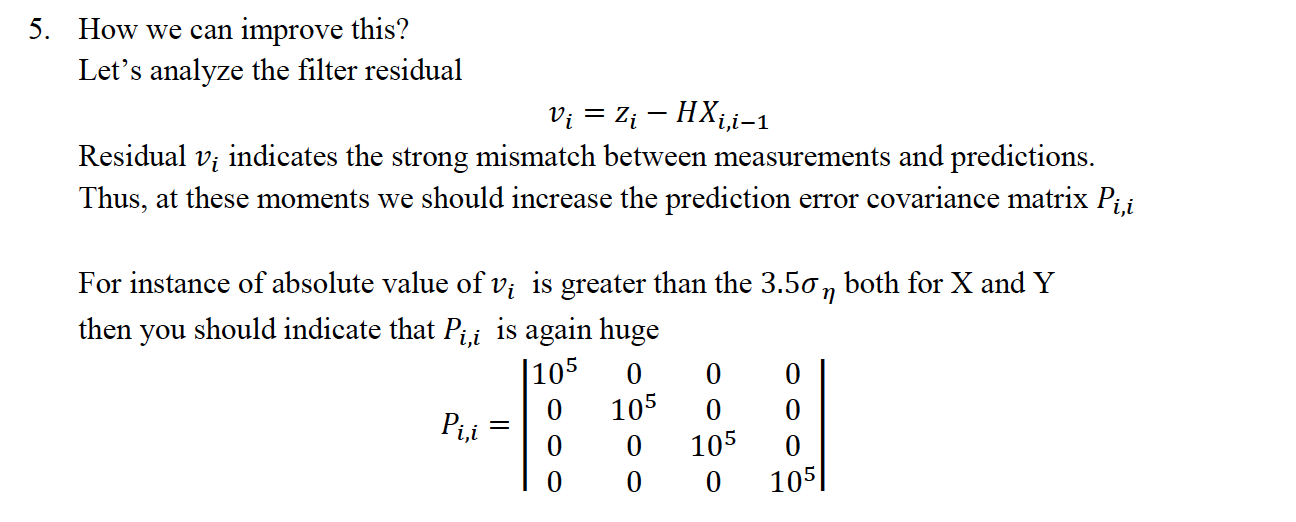

In [119]:
initial_y_residual = np.zeros((r.shape[0], 2))
initial_y_residual = r

data = [
    go.Scatter(
        y=abs(r[:, 0]),
        name='measured trajectory x',
    ),
    
    go.Scatter(
        y=abs(r[:, 1]),
        name='measured trajectory y',
    ),
]

layout= go.Layout(
    title= 'Residuals',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'Y',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

In [120]:
def kalman_with_reset_of_P(msr, var_acc, var_n, T = 1, S0 = S0, P0 = P0):
    
    size = msr.shape
    
    F = np.array([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])
    G = np.array([[(T**2)/2, 0], [T, 0], [0, (T**2)/2], [0, T]])
    Q = G.dot(G.T)*var_acc # state noise
    H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
    R = np.array([[var_n, 0], [0, var_n]]) # measurement noise
    Ph = np.eye(4)*(10**5) # 4x4
    
    # allocate space for arrays
    P = np.zeros((size[0], 4, 4))
    X = np.zeros((size[0], 4))
    P_ = np.zeros((size[0], 4, 4))
    X_ = np.zeros((size[0], 4))
    K = np.zeros((size[0], 4, 2))
    v = np.zeros((size[0], 2))
    
    # intial guesses
    X_[0] = S0
    P_[0] = P0
    
    for k in range(1, size[0]):
        
        # Prediction
        X[k] = np.dot(F, X_[k-1])
        P[k] = np.dot(F, np.dot(P_[k-1], F.T)) + Q
        
        # Update
        K[k] = (P[k].dot(H.T)).dot(np.linalg.inv(H.dot(P[k].dot(H.T)) + R))
        v[k] = msr[k] -  np.dot(H, X[k]) # measured minus predicted
        X_[k] = X[k] + K[k].dot(v[k])
        if all(abs(v[k]) > 2.5*np.sqrt(var_n)):
            P_[k] = Ph
        else:
            P_[k] = (np.eye(4) - np.dot(K[k], H)).dot(P[k])
        
    return X, X_, v, np.sqrt(P[:,0,0]), np.sqrt(P_[:,0,0])

In [121]:
X, X_, v, P, P_ = kalman_with_reset_of_P(z, var_acc = 0.01**2, var_n = 10**2)

In [122]:
data = [
    go.Scatter(
        x=msr_x,
        y=msr_y,
        name='measured trajectory',
        mode='markers'
    ),
    go.Scatter(
        x = X_[:, 0],
        y = X_[:, 2],
        name='filtered trajectory',
    ),
]

layout= go.Layout(
    title= 'Estimated trajectory with Kalman filter',
    xaxis= dict(
        title= 'X',
    ),
    yaxis=dict(
        title= 'Y',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

In [123]:
data = [
    go.Scatter(
        y = X[:, 2],
        name='predicted y-coord',
        #mode='markers'
    ),
    go.Scatter(
        y = X_[:, 2],
        name='filtered y-coord',
    ),
    go.Scatter(
        y = msr_y,
        name='measured by GPS y-coord',
        mode='markers'
    ),
]

layout= go.Layout(
    title= 'Estimated trajectory with Kalman filter',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'Y',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

In [124]:
data = [
    go.Scatter(
        y = X[:, 0],
        name='predicted x-coord',
    ),
    go.Scatter(
        y = X_[:, 0],
        name='filtered x-coord',
    ),
    go.Scatter(
        y = msr_x,
        name='measured by GPS',
        mode='markers'
    ),
]

layout= go.Layout(
    title= 'Estimated trajectory with Kalman filter',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

In [125]:
data = [
    go.Scatter(
        y = P_,
        name='P_',
    ),
]

layout= go.Layout(
    title= 'Error covariance',
    xaxis= dict(
        title= 'X',
    ),
    yaxis=dict(
        title= 'Y',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

In [126]:
reset_P_y_residual = np.zeros((r.shape[0], 2))
reset_P_y_residual = v

#### We have only one resetting of error covariance matrix because there is only one case when both X and Y residuals are "huge" enough
#### Such approach leads to some spikes in the point where error covariance matrix is set to huge value again.

#### Important point is that we have turn of the vehicle here, so angles theta between x and y are changing between steps i and i-1. So, let's increase the covariance matrix of state noise that will result in a greater filter gain 𝐾, and thus more confidence to measurements. By increasing the variance of the random acceleration we compensate imperfections of the motion model.

#### Let's try the variance ~ 0.03

In [127]:
X, X_, v, P, P_ = kalman_with_reset_of_P(z, var_acc = 0.03**2, var_n = 10**2)

In [128]:
data = [
    go.Scatter(
        x=msr_x,
        y=msr_y,
        name='measured trajectory',
        mode='markers'
    ),
    go.Scatter(
        x = X_[:, 0],
        y = X_[:, 2],
        name='filtered trajectory',
    ),
]

layout= go.Layout(
    title= 'Estimated trajectory with Kalman filter',
    xaxis= dict(
        title= 'X',
    ),
    yaxis=dict(
        title= 'Y',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

In [129]:
data = [
    go.Scatter(
        y = X[:, 2],
        name='predicted y-coord',
    ),
    go.Scatter(
        y = X_[:, 2],
        name='filtered y-coord',
    ),
    go.Scatter(
        y = msr_y,
        name='measured by GPS y-coord',
        mode='markers'
    ),
]

layout= go.Layout(
    title= 'Estimated trajectory with Kalman filter',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'Y',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

In [130]:
data = [
    go.Scatter(
        y = X[:, 0],
        name='predicted x-coord',
    ),
    go.Scatter(
        y = X_[:, 0],
        name='filtered x-coord',
    ),
    go.Scatter(
        y = msr_x,
        name='measured by GPS',
        mode='markers'
    ),
]

layout= go.Layout(
    title= 'Estimated trajectory with Kalman filter',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

In [131]:
data = [
    go.Scatter(
        y = P_,
        name='P_',
    ),
]

layout= go.Layout(
    title= 'Error covariance',
    xaxis= dict(
        title= 'X',
    ),
    yaxis=dict(
        title= 'Y',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

#### There is no any huge residual when the variance is 0.03

#### Now let's try the variance ~ 0.05

In [132]:
X, X_, v, P, P_ = kalman_with_reset_of_P(z, var_acc = 0.05**2, var_n = 10**2)

In [133]:
data = [
    go.Scatter(
        x=msr_x,
        y=msr_y,
        name='measured trajectory',
        mode='markers'
    ),
    go.Scatter(
        x = X_[:, 0],
        y = X_[:, 2],
        name='filtered trajectory',
    ),
]

layout= go.Layout(
    title= 'Estimated trajectory with Kalman filter',
    xaxis= dict(
        title= 'X',
    ),
    yaxis=dict(
        title= 'Y',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

In [134]:
data = [
    go.Scatter(
        y = X[:, 2],
        name='predicted y-coord',
    ),
    go.Scatter(
        y = X_[:, 2],
        name='filtered y-coord',
    ),
    go.Scatter(
        y = msr_y,
        name='measured by GPS y-coord',
        mode='markers'
    ),
]

layout= go.Layout(
    title= 'Estimated trajectory with Kalman filter',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'Y',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

#### There is no any huge residual when the variance is 0.05

In [135]:
data = [
    go.Scatter(
        y = X[:, 0],
        name='predicted x-coord',
    ),
    go.Scatter(
        y = X_[:, 0],
        name='filtered x-coord',
    ),
    go.Scatter(
        y = msr_x,
        name='measured by GPS',
        mode='markers'
    ),
]

layout= go.Layout(
    title= 'Estimated trajectory with Kalman filter',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

In [136]:
data = [
    go.Scatter(
        y = P_,
        name='P_',
    ),
]

layout= go.Layout(
    title= 'Error covariance',
    xaxis= dict(
        title= 'X',
    ),
    yaxis=dict(
        title= 'Y',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

In [137]:
data = [
    go.Scatter(
        y=abs(v[:, 1]) + 100,
        name='y residual when var 0.05',
    ),

    go.Scatter(
            y=abs(reset_P_y_residual[:, 1]) + 50,
            name='y residual when var 0.01 with reset of P',
        ),
      go.Scatter(
            y=abs(initial_y_residual[:, 1]),
            name='initial y residual ',
        ),
]

layout= go.Layout(
    title= 'Residuals',
    xaxis= dict(
        title= 'X',
    ),
    yaxis=dict(
        title= 'Y',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

#### According to the graphic it is clear that initial huge y residual is eliminated both by reseting P approach and by changing variation of random acceleration to 0.05

In [138]:
data = [
    go.Scatter(
        y=abs((reset_P_y_residual[:, 1]) - (v[:, 1])),
        name='delta between (0.01 + resetP) and 0.05',
    ),
]

layout= go.Layout(
    title= 'Delta between (0.01 + resetP) and 0.05',
    xaxis= dict(
        title = 'Step',
    ),
    yaxis=dict(
        title = 'Residual delta',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

#### For "Reset P" approach Y residual in the moment of turn is bigger than for changing of variaton

#### In our case we have detected that the variance of random acceleration should be about 0.03 - 0.05

## Conclusion

### We see that on the one hand we can increase error covariance matrix to huge value again when we get "huge" residual for filtered and measured values. In this case we will get filtered values with ejections in the points of "huge" residual. 
### But on the other hand we can increase the variance of the random acceleration we compensate imperfections of the motion model as was discussed above. In this case we have big residuals but no so "huge" as in little acceleration variance.
### As we see, the second approach gives better results especially when we have data with not so large amount of huge residuals for X and Y simultaniously. 